In [1]:
import numpy as np # Successfully installed numpy-1.23.5
import pandas as pd # Successfully installed pandas-1.3.5
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx

import torch
import torch.nn.functional as F
#from torch_geometric.nn import GCNConv
# from torch_geometric.data import Data
# the temporal package is not available TODO: find what the issue is
# from torch_geometric_temporal.nn.recurrent import A3TGCN2 # torch-geometric-temporal 0.54.0 requires pandas<=1.3.5, but you have pandas 2.2.3 which is incompatible.
#from torch_geometric_temporal.signal import temporal_signal_split
# import 
# Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
# from stellargraph import StellarGraph
# import custom functions from utils.py
# from utils import *
os.getcwd() # double check current working directory

'c:\\Users\\rober\\GitHub\\CAN-Graph\\notebooks'

In [24]:
# .. goes up one level in directory
path = r'../datasets/Car-Hacking Dataset/Fuzzy_dataset.csv'

df = pd.read_csv(path)
df.columns = ['Timestamp', 'CAN ID','DLC','Data1','Data2','Data3','Data4','Data5','Data6','Data7','Data8', 'label'] 

In [25]:
df

,Timestamp,CAN ID,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R
...,...,...,...,...,...,...,...,...,...,...,...,...
3838854,1.478201e+09,018f,8,fe,59,00,00,00,41,00,00,R
3838855,1.478201e+09,0260,8,18,21,21,30,08,8f,6d,19,R
3838856,1.478201e+09,02a0,8,24,00,9a,1d,97,02,bd,00,R
3838857,1.478201e+09,0329,8,dc,b7,7f,14,11,20,00,14,R


In [26]:
df['label'].value_counts()  

label
R    3259176
T     491847
Name: count, dtype: int64

In [ ]:
'''
Temporal graph dataset: a graph that changes over time
Graph type: Homogeneous graph
Nodes: CAN ID
Edges: The next CAN ID in the sequence
Node Features (optional): The data in the CAN ID

Steps:
1. identify node properties
2. Edges: How to connect nodes?
3. Extract labels

Convert to pytorch geometric format
One graph to another graph: 200 messages to 1 graph

There is also pytorch geometric temporal package

# build a baseline model RF, SVM, etc

# fraud datasets may have incorrect labels -> use label smoothing
Featureless nodes: use random numbers

make a GCN that uses labels only, and one that takes an average of data form its neighbors as well
Graph Attention Networks (GAT)

Idea: could I use FL on the different car datasets, share those weights and perhaps it could generalize better. A practical use case would be between different companies, where they don't want to share their data
but it is in their best interest to have the best performing cybersecurity model.

https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html
'''

In [27]:
df['Node'] = df['CAN ID']
df['Edge'] = df['CAN ID'].shift(-1)


In [ ]:
# # Extract edge indices
# edge_index = torch.tensor(df[['Node', 'Edge']].values.T,) # dtype=torch.long)

# # Extract node features (assuming features are in columns 'feature1', 'feature2', ..., 'featureN')
# node_features = torch.tensor(df[['Data1','Data2','Data3','Data4','Data5','Data6','Data7','Data8',]].values, dtype=torch.float)

# # Create a Data object
# data = Data(x=node_features, edge_index=edge_index)

In [34]:
df['label'].value_counts()

label
R    3259176
T     491847
Name: count, dtype: int64

In [55]:
graph = df[['Node', 'Edge', 'label']].copy(deep=True)
color = {'R': 'blue',
         'T': 'red'}
graph['color'] = graph['label'].map(color)
# graph = graph[:-1] # omit last row as it doesn't have an edge (or just make it a blank connection)
# graph of the last 200 messages
graph_200 = graph[500:700]# create window size
graph_200_no200 = graph[1500:1700]     
# graph_200 = graph[:-200] # create window size

In [ ]:
graph['label'].value_counts()

label
R    3259176
T     491847
Name: count, dtype: int64

In [56]:
graph_200

,Node,Edge,label,color
500,043f,0440,R,blue
501,0440,0316,R,blue
502,0316,018f,R,blue
503,018f,0260,R,blue
504,0260,02a0,R,blue
...,...,...,...,...
695,0140,0440,R,blue
696,0440,0316,R,blue
697,0316,018f,R,blue
698,018f,0260,R,blue


In [57]:
graph_200['label'].value_counts()

label
R    188
Name: count, dtype: int64

In [58]:
graph_200_no200['label'].value_counts()

label
R    130
T     56
Name: count, dtype: int64

In [16]:
# maybe I could make weights based on the {node, edge} count in the window size

G =  nx.DiGraph()
for index, element in graph_200.iterrows():
    G.add_edge(element['Node'], element['Edge'])


In [17]:
# Create a color map
df= graph_200
unique_labels = df['label'].unique()
color_map = {label: plt.cm.get_cmap('Set1')(i/len(unique_labels)) for i, label in enumerate(unique_labels)}
# Create a dictionary mapping nodes to colors
node_colors = df.set_index('Node')['label'].map(color_map).to_dict()

C:\Users\rober\AppData\Local\Temp\ipykernel_25632\1834303822.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {label: plt.cm.get_cmap('Set1')(i/len(unique_labels)) for i, label in enumerate(unique_labels)}


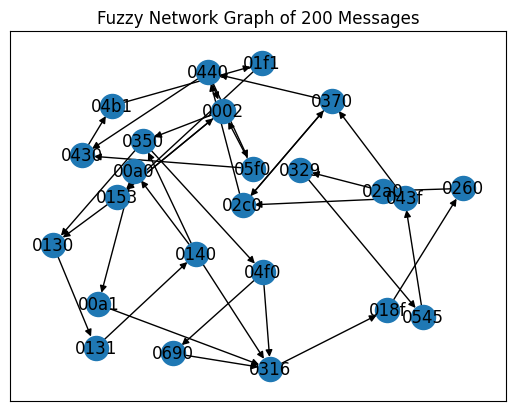

In [ ]:
layouts = {'spring' : nx.spring_layout(G, k=1),
           'spiral': nx.spiral_layout(G),
           'spectral': nx.spectral_layout(G),
           'random': nx.random_layout(G),
           'circle': nx.circular_layout(G),
           }

# node_color= [node_colors[node] for node in G.nodes()],
nx.draw_networkx(G, pos=layouts['spring'], with_labels = True)
plt.title("Fuzzy Network Graph of 200 Messages")

plt.show()

In [ ]:
'''   
- Turn the graph into a pytorch geometric dataset
- simple training with a basic GNN
'''